# Plan 3 : AXISX CLAMP (28x28) image 개별 학습

## 1. Data Preprocessing

In [39]:
import os, re, glob
#import cv2
import numpy as np
#from keras.preprocessing import image
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input

In [40]:
groups_folder_path = './resources/imgs28x28/'
# AXISX 2, 5, 6, 7 CLAMP 2, 3, 5, 6
AXISX_categ = ["AXISX2", "AXISX5", "AXISX6", "AXISX7"]
CLAMP_categ = ["CLAMP2", "CLAMP3", "CLAMP5", "CLAMP6"]
num_classes = 4

In [41]:
image_w = 28
image_h = 28
X = []
Y = []

### - X: image data , Y: class number

In [42]:
def setData_XY(groups_folder_path, category, image_w, image_h):
    X = []
    Y = []
    #data_path = os.listdir(groups_folder_path)
    #print(data_path)
    for filepath in category:
        print(filepath)
        filepath = groups_folder_path + filepath
        files = os.listdir(filepath)
        for data in files:
            img_path = "{0}/{1}".format(filepath, data) # 이미지 경로 확인
            # 이미지 열고 알맞은 사이즈로 저장하기 
            image = Image.open(img_path)
            image = image.convert('L')#흑백으로 맹글기
            #image = image.resize((image_w, image_h))
            img_data = np.array(image)
            img_data = img_data.reshape((image_w, image_h, 1))

            X.append(np.array(img_data))

            seg = data.split('_')[3][0]
            seg = int(seg)

            Y.append(seg)
    return X, Y

#X, Y = setData_XY(groups_folder_path, CLAMP_categ, image_w, image_h)
#X, Y = setData_XY(groups_folder_path, AXISX_categ, image_w, image_h)

['AXISX1', 'AXISX2', 'AXISX3', 'AXISX4', 'AXISX5', 'AXISX6', 'AXISX7', 'CLAMP1', 'CLAMP2', 'CLAMP3', 'CLAMP4', 'CLAMP5', 'CLAMP6']
CLAMP2
CLAMP3
CLAMP5
CLAMP6


In [43]:
X = np.array(X)
Y = np.array(Y)
print("{}, {}".format(X.shape, Y.shape))
print(X, Y)

(760, 28, 28, 1), (760,)
[[[[153]
   [255]
   [255]
   ...
   [172]
   [  5]
   [  0]]

  [[161]
   [255]
   [255]
   ...
   [125]
   [  0]
   [  5]]

  [[186]
   [254]
   [255]
   ...
   [ 80]
   [125]
   [172]]

  ...

  [[255]
   [242]
   [175]
   ...
   [255]
   [255]
   [255]]

  [[245]
   [184]
   [242]
   ...
   [254]
   [255]
   [255]]

  [[194]
   [245]
   [255]
   ...
   [186]
   [161]
   [153]]]


 [[[209]
   [239]
   [255]
   ...
   [255]
   [233]
   [145]]

  [[248]
   [223]
   [253]
   ...
   [251]
   [173]
   [233]]

  [[255]
   [241]
   [222]
   ...
   [228]
   [251]
   [255]]

  ...

  [[255]
   [245]
   [200]
   ...
   [222]
   [253]
   [255]]

  [[246]
   [214]
   [245]
   ...
   [241]
   [223]
   [239]]

  [[191]
   [246]
   [255]
   ...
   [255]
   [248]
   [209]]]


 [[[154]
   [255]
   [255]
   ...
   [206]
   [  8]
   [  0]]

  [[152]
   [255]
   [255]
   ...
   [158]
   [  2]
   [  8]]

  [[169]
   [254]
   [255]
   ...
   [ 95]
   [158]
   [206]]

  ...

  [[2

### - 학습 셋, 훈련 셋 나누기

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

print("{}, {}".format(X_train.shape, Y_train.shape))
print("{}, {}".format(X_test.shape, Y_test.shape))

(570, 28, 28, 1), (570,)
(190, 28, 28, 1), (190,)


## 2. Model

In [45]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.layers import Flatten, Convolution2D, MaxPooling2D
from keras.models import load_model

### - Normalization

In [46]:
# 데이터 정규화 하기
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### - 모델 생성 및 훈련 (Auto encoder)

In [47]:
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
input_shape=(28,28,1)
model = Sequential()
 
#1st convolution layer
model.add(Conv2D(16, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
, padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
 
#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
 
#here compressed version
 
#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))
 
#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))
 
model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 2)         290       
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 2)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 2)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 2)          

In [48]:
#학습
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(X_train, X_train, epochs=7000, validation_data=(X_test, X_test))
model.save_weights('CLAMP_weights.h5')

Epoch 1/7000
18/18 [==============================] - 0s 11ms/step - loss: 0.6767 - val_loss: 0.6422
Epoch 2/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.6154 - val_loss: 0.6007
Epoch 3/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.5936 - val_loss: 0.5866
Epoch 4/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.5779 - val_loss: 0.5691
Epoch 5/7000
18/18 [==============================] - 0s 7ms/step - loss: 0.5573 - val_loss: 0.5476
Epoch 6/7000
18/18 [==============================] - 0s 8ms/step - loss: 0.5346 - val_loss: 0.5271
Epoch 7/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.5127 - val_loss: 0.5073
Epoch 8/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4954 - val_loss: 0.4966
Epoch 9/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4870 - val_loss: 0.4910
Epoch 10/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4818 - val_loss: 0.486

18/18 [==============================] - 0s 5ms/step - loss: 0.4363 - val_loss: 0.4453
Epoch 83/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4361 - val_loss: 0.4451
Epoch 84/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4362 - val_loss: 0.4450
Epoch 85/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4361 - val_loss: 0.4451
Epoch 86/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4359 - val_loss: 0.4447
Epoch 87/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4357 - val_loss: 0.4447
Epoch 88/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4356 - val_loss: 0.4445
Epoch 89/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4355 - val_loss: 0.4444
Epoch 90/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4354 - val_loss: 0.4443
Epoch 91/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4353 - val_loss: 0.4442
Epoc

18/18 [==============================] - 0s 5ms/step - loss: 0.4310 - val_loss: 0.4404
Epoch 163/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4310 - val_loss: 0.4406
Epoch 164/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4310 - val_loss: 0.4400
Epoch 165/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4308 - val_loss: 0.4399
Epoch 166/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4308 - val_loss: 0.4399
Epoch 167/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4308 - val_loss: 0.4399
Epoch 168/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4307 - val_loss: 0.4398
Epoch 169/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4307 - val_loss: 0.4398
Epoch 170/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4306 - val_loss: 0.4397
Epoch 171/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4306 - val_loss: 0.

18/18 [==============================] - 0s 5ms/step - loss: 0.4284 - val_loss: 0.4377
Epoch 243/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4284 - val_loss: 0.4377
Epoch 244/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4284 - val_loss: 0.4376
Epoch 245/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4284 - val_loss: 0.4376
Epoch 246/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4283 - val_loss: 0.4376
Epoch 247/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4284 - val_loss: 0.4377
Epoch 248/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4283 - val_loss: 0.4376
Epoch 249/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4283 - val_loss: 0.4381
Epoch 250/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4283 - val_loss: 0.4378
Epoch 251/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4283 - val_loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.4270 - val_loss: 0.4363
Epoch 323/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4269 - val_loss: 0.4362
Epoch 324/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4268 - val_loss: 0.4362
Epoch 325/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4268 - val_loss: 0.4361
Epoch 326/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4268 - val_loss: 0.4361
Epoch 327/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4268 - val_loss: 0.4361
Epoch 328/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4268 - val_loss: 0.4363
Epoch 329/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4268 - val_loss: 0.4362
Epoch 330/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4267 - val_loss: 0.4361
Epoch 331/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4267 - val_loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.4258 - val_loss: 0.4351
Epoch 403/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4258 - val_loss: 0.4355
Epoch 404/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4259 - val_loss: 0.4354
Epoch 405/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4258 - val_loss: 0.4351
Epoch 406/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4257 - val_loss: 0.4351
Epoch 407/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4259 - val_loss: 0.4351
Epoch 408/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4258 - val_loss: 0.4351
Epoch 409/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4257 - val_loss: 0.4350
Epoch 410/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4257 - val_loss: 0.4351
Epoch 411/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4258 - val_loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.4251 - val_loss: 0.4344
Epoch 483/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4251 - val_loss: 0.4344
Epoch 484/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4251 - val_loss: 0.4344
Epoch 485/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4251 - val_loss: 0.4348
Epoch 486/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4251 - val_loss: 0.4344
Epoch 487/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4250 - val_loss: 0.4344
Epoch 488/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4250 - val_loss: 0.4344
Epoch 489/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4250 - val_loss: 0.4344
Epoch 490/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4250 - val_loss: 0.4343
Epoch 491/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4250 - val_loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.4246 - val_loss: 0.4340
Epoch 563/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4246 - val_loss: 0.4340
Epoch 564/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4246 - val_loss: 0.4340
Epoch 565/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4246 - val_loss: 0.4339
Epoch 566/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4245 - val_loss: 0.4340
Epoch 567/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4246 - val_loss: 0.4340
Epoch 568/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4247 - val_loss: 0.4339
Epoch 569/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4245 - val_loss: 0.4339
Epoch 570/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4245 - val_loss: 0.4339
Epoch 571/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4245 - val_loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.4245 - val_loss: 0.4342
Epoch 643/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4245 - val_loss: 0.4337
Epoch 644/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4242 - val_loss: 0.4336
Epoch 645/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4242 - val_loss: 0.4337
Epoch 646/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4242 - val_loss: 0.4336
Epoch 647/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4245 - val_loss: 0.4336
Epoch 648/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4243 - val_loss: 0.4336
Epoch 649/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4242 - val_loss: 0.4336
Epoch 650/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4242 - val_loss: 0.4336
Epoch 651/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4242 - val_loss: 0.

18/18 [==============================] - 0s 5ms/step - loss: 0.4241 - val_loss: 0.4336
Epoch 723/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4241 - val_loss: 0.4335
Epoch 724/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4240 - val_loss: 0.4334
Epoch 725/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4240 - val_loss: 0.4334
Epoch 726/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4240 - val_loss: 0.4334
Epoch 727/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4240 - val_loss: 0.4334
Epoch 728/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4240 - val_loss: 0.4334
Epoch 729/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4239 - val_loss: 0.4333
Epoch 730/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4239 - val_loss: 0.4333
Epoch 731/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4239 - val_loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.4238 - val_loss: 0.4333
Epoch 803/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4238 - val_loss: 0.4333
Epoch 804/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4238 - val_loss: 0.4332
Epoch 805/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4237 - val_loss: 0.4334
Epoch 806/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4237 - val_loss: 0.4332
Epoch 807/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4237 - val_loss: 0.4332
Epoch 808/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4238 - val_loss: 0.4333
Epoch 809/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4238 - val_loss: 0.4331
Epoch 810/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4237 - val_loss: 0.4331
Epoch 811/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4238 - val_loss: 0.

18/18 [==============================] - 0s 5ms/step - loss: 0.4237 - val_loss: 0.4332
Epoch 883/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4236 - val_loss: 0.4330
Epoch 884/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4236 - val_loss: 0.4330
Epoch 885/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4236 - val_loss: 0.4330
Epoch 886/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4236 - val_loss: 0.4330
Epoch 887/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4236 - val_loss: 0.4330
Epoch 888/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4235 - val_loss: 0.4330
Epoch 889/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4236 - val_loss: 0.4330
Epoch 890/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4236 - val_loss: 0.4331
Epoch 891/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4236 - val_loss: 0.

18/18 [==============================] - 0s 5ms/step - loss: 0.4234 - val_loss: 0.4329
Epoch 963/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4234 - val_loss: 0.4328
Epoch 964/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4234 - val_loss: 0.4328
Epoch 965/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4234 - val_loss: 0.4328
Epoch 966/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4235 - val_loss: 0.4330
Epoch 967/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4235 - val_loss: 0.4328
Epoch 968/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4234 - val_loss: 0.4328
Epoch 969/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4234 - val_loss: 0.4329
Epoch 970/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4235 - val_loss: 0.4330
Epoch 971/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4235 - val_loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.4233 - val_loss: 0.4328
Epoch 1043/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4233 - val_loss: 0.4327
Epoch 1044/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4233 - val_loss: 0.4328
Epoch 1045/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4234 - val_loss: 0.4327
Epoch 1046/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4233 - val_loss: 0.4328
Epoch 1047/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4233 - val_loss: 0.4328
Epoch 1048/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4236 - val_loss: 0.4328
Epoch 1049/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4234 - val_loss: 0.4327
Epoch 1050/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4233 - val_loss: 0.4327
Epoch 1051/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4233 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4231 - val_loss: 0.4327
Epoch 1122/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4232 - val_loss: 0.4326
Epoch 1123/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4231 - val_loss: 0.4326
Epoch 1124/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4233 - val_loss: 0.4328
Epoch 1125/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4232 - val_loss: 0.4326
Epoch 1126/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4231 - val_loss: 0.4326
Epoch 1127/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4231 - val_loss: 0.4327
Epoch 1128/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4231 - val_loss: 0.4327
Epoch 1129/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4232 - val_loss: 0.4328
Epoch 1130/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4233 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4231 - val_loss: 0.4326
Epoch 1201/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4231 - val_loss: 0.4325
Epoch 1202/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4230 - val_loss: 0.4326
Epoch 1203/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val_loss: 0.4325
Epoch 1204/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val_loss: 0.4325
Epoch 1205/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val_loss: 0.4326
Epoch 1206/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4230 - val_loss: 0.4325
Epoch 1207/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val_loss: 0.4325
Epoch 1208/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val_loss: 0.4326
Epoch 1209/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val_loss: 0.4323
Epoch 1280/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4324
Epoch 1281/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4324
Epoch 1282/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4229 - val_loss: 0.4324
Epoch 1283/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4327
Epoch 1284/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4231 - val_loss: 0.4324
Epoch 1285/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4231 - val_loss: 0.4324
Epoch 1286/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4229 - val_loss: 0.4324
Epoch 1287/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4325
Epoch 1288/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4230 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4228 - val_loss: 0.4324
Epoch 1359/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4229 - val_loss: 0.4323
Epoch 1360/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4229 - val_loss: 0.4323
Epoch 1361/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4229 - val_loss: 0.4326
Epoch 1362/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4323
Epoch 1363/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4230 - val_loss: 0.4323
Epoch 1364/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4324
Epoch 1365/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4228 - val_loss: 0.4322
Epoch 1366/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4228 - val_loss: 0.4324
Epoch 1367/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4228 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4322
Epoch 1438/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4228 - val_loss: 0.4324
Epoch 1439/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4228 - val_loss: 0.4322
Epoch 1440/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4324
Epoch 1441/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4229 - val_loss: 0.4324
Epoch 1442/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4228 - val_loss: 0.4324
Epoch 1443/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4228 - val_loss: 0.4322
Epoch 1444/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4227 - val_loss: 0.4323
Epoch 1445/7000
18/18 [==============================] - ETA: 0s - loss: 0.423 - 0s 4ms/step - loss: 0.4227 - val_loss: 0.4322
Epoch 1446/7000
18/18 [==============================] - 0s 4ms/s

18/18 [==============================] - 0s 5ms/step - loss: 0.4226 - val_loss: 0.4321
Epoch 1517/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4227 - val_loss: 0.4323
Epoch 1518/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4227 - val_loss: 0.4321
Epoch 1519/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4321
Epoch 1520/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4227 - val_loss: 0.4321
Epoch 1521/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4321
Epoch 1522/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4227 - val_loss: 0.4321
Epoch 1523/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4226 - val_loss: 0.4324
Epoch 1524/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4228 - val_loss: 0.4325
Epoch 1525/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4228 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4321
Epoch 1596/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4226 - val_loss: 0.4322
Epoch 1597/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4320
Epoch 1598/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.4320
Epoch 1599/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4320
Epoch 1600/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4225 - val_loss: 0.4320
Epoch 1601/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4322
Epoch 1602/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4322
Epoch 1603/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4226 - val_loss: 0.4320
Epoch 1604/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4224 - val_loss: 0.4320
Epoch 1675/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.4320
Epoch 1676/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4227 - val_loss: 0.4323
Epoch 1677/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4320
Epoch 1678/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.4321
Epoch 1679/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.4319
Epoch 1680/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4224 - val_loss: 0.4319
Epoch 1681/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val_loss: 0.4319
Epoch 1682/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4225 - val_loss: 0.4320
Epoch 1683/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4223 - val_loss: 0.4318
Epoch 1754/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val_loss: 0.4324
Epoch 1755/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val_loss: 0.4318
Epoch 1756/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val_loss: 0.4318
Epoch 1757/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val_loss: 0.4320
Epoch 1758/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4224 - val_loss: 0.4319
Epoch 1759/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4223 - val_loss: 0.4318
Epoch 1760/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val_loss: 0.4319
Epoch 1761/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4224 - val_loss: 0.4320
Epoch 1762/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4226 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4318
Epoch 1833/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4318
Epoch 1834/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4317
Epoch 1835/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.4319
Epoch 1836/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4319
Epoch 1837/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4318
Epoch 1838/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4327
Epoch 1839/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4226 - val_loss: 0.4323
Epoch 1840/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4225 - val_loss: 0.4320
Epoch 1841/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4318
Epoch 1912/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4317
Epoch 1913/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4222 - val_loss: 0.4318
Epoch 1914/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4318
Epoch 1915/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4222 - val_loss: 0.4317
Epoch 1916/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4222 - val_loss: 0.4320
Epoch 1917/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4224 - val_loss: 0.4318
Epoch 1918/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4222 - val_loss: 0.4317
Epoch 1919/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4222 - val_loss: 0.4317
Epoch 1920/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4222 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4316
Epoch 1991/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4222 - val_loss: 0.4316
Epoch 1992/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4221 - val_loss: 0.4316
Epoch 1993/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4221 - val_loss: 0.4317
Epoch 1994/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4221 - val_loss: 0.4316
Epoch 1995/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4221 - val_loss: 0.4317
Epoch 1996/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4221 - val_loss: 0.4316
Epoch 1997/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4222 - val_loss: 0.4317
Epoch 1998/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4222 - val_loss: 0.4317
Epoch 1999/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4224 - val_loss: 0.4315
Epoch 2070/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4316
Epoch 2071/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4315
Epoch 2072/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4220 - val_loss: 0.4315
Epoch 2073/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4315
Epoch 2074/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4316
Epoch 2075/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4315
Epoch 2076/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4315
Epoch 2077/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4220 - val_loss: 0.4317
Epoch 2078/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4315
Epoch 2149/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4220 - val_loss: 0.4316
Epoch 2150/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4220 - val_loss: 0.4316
Epoch 2151/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4221 - val_loss: 0.4315
Epoch 2152/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4223 - val_loss: 0.4322
Epoch 2153/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4222 - val_loss: 0.4315
Epoch 2154/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4220 - val_loss: 0.4315
Epoch 2155/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4220 - val_loss: 0.4315
Epoch 2156/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4220 - val_loss: 0.4315
Epoch 2157/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4220 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val_loss: 0.4314
Epoch 2228/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val_loss: 0.4315
Epoch 2229/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4220 - val_loss: 0.4315
Epoch 2230/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4220 - val_loss: 0.4315
Epoch 2231/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4314
Epoch 2232/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4314
Epoch 2233/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4220 - val_loss: 0.4314
Epoch 2234/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4317
Epoch 2235/7000
18/18 [==============================] - 0s 6ms/step - loss: 0.4220 - val_loss: 0.4314
Epoch 2236/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val_loss: 0.4316
Epoch 2307/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4314
Epoch 2308/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4314
Epoch 2309/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4314
Epoch 2310/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val_loss: 0.4313
Epoch 2311/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val_loss: 0.4313
Epoch 2312/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4314
Epoch 2313/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val_loss: 0.4314
Epoch 2314/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4313
Epoch 2315/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4315
Epoch 2386/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4314
Epoch 2387/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4313
Epoch 2388/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4317
Epoch 2389/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4314
Epoch 2390/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4313
Epoch 2391/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4313
Epoch 2392/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4313
Epoch 2393/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4313
Epoch 2394/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4220 - val_loss: 0.4315
Epoch 2465/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2466/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4315
Epoch 2467/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4314
Epoch 2468/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2469/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2470/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4314
Epoch 2471/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2472/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4312
Epoch 2473/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2544/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2545/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4219 - val_loss: 0.4317
Epoch 2546/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4218 - val_loss: 0.4315
Epoch 2547/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4313
Epoch 2548/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4314
Epoch 2549/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4312
Epoch 2550/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4313
Epoch 2551/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2552/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4312
Epoch 2623/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2624/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4312
Epoch 2625/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4312
Epoch 2626/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4316
Epoch 2627/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4219 - val_loss: 0.4312
Epoch 2628/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4312
Epoch 2629/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4313
Epoch 2630/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4312
Epoch 2631/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4311
Epoch 2702/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2703/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4313
Epoch 2704/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4218 - val_loss: 0.4312
Epoch 2705/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4317
Epoch 2706/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4220 - val_loss: 0.4313
Epoch 2707/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4311
Epoch 2708/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2709/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4311
Epoch 2710/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 2781/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4216 - val_loss: 0.4315
Epoch 2782/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2783/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2784/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4311
Epoch 2785/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4312
Epoch 2786/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4313
Epoch 2787/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2788/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2789/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4312
Epoch 2860/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2861/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 2862/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4310
Epoch 2863/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2864/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 2865/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4310
Epoch 2866/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 2867/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2868/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 2939/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 2940/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 2941/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4314
Epoch 2942/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4310
Epoch 2943/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 2944/7000
18/18 [==============================] - 0s 6ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 2945/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 2946/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4310
Epoch 2947/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3018/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3019/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 3020/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4311
Epoch 3021/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4312
Epoch 3022/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4315
Epoch 3023/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4313
Epoch 3024/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4312
Epoch 3025/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3026/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3097/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3098/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3099/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3100/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3101/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3102/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3103/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3104/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3105/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4216 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3176/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 3177/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 3178/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4309
Epoch 3179/7000
18/18 [==============================] - ETA: 0s - loss: 0.419 - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3180/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3181/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3182/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3183/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3184/7000
18/18 [==============================] - 0s 4ms/s

18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3255/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3256/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4312
Epoch 3257/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4313
Epoch 3258/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3259/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3260/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3261/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3262/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3263/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3334/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4309
Epoch 3335/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4310
Epoch 3336/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3337/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3338/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3339/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3340/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4312
Epoch 3341/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3342/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3413/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3414/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4310
Epoch 3415/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3416/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4309
Epoch 3417/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4310
Epoch 3418/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3419/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4311
Epoch 3420/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4308
Epoch 3421/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 3492/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3493/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3494/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3495/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4310
Epoch 3496/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4308
Epoch 3497/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3498/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3499/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3500/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 3571/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3572/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3573/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4308
Epoch 3574/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4315
Epoch 3575/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4308
Epoch 3576/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4310
Epoch 3577/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4308
Epoch 3578/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3579/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3650/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3651/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4313
Epoch 3652/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4217 - val_loss: 0.4312
Epoch 3653/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4216 - val_loss: 0.4310
Epoch 3654/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4310
Epoch 3655/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3656/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3657/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3658/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3729/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4311
Epoch 3730/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4310
Epoch 3731/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4310
Epoch 3732/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4317
Epoch 3733/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4309
Epoch 3734/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3735/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 3736/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4310
Epoch 3737/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3808/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3809/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3810/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3811/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3812/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 3813/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3814/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3815/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 3816/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4213 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 3887/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3888/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 3889/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4311
Epoch 3890/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3891/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3892/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4310
Epoch 3893/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4308
Epoch 3894/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3895/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 3966/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3967/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3968/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4309
Epoch 3969/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3970/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 3971/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 3972/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3973/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 3974/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 4045/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4309
Epoch 4046/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4309
Epoch 4047/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 4048/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4310
Epoch 4049/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 4050/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4051/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4215 - val_loss: 0.4312
Epoch 4052/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4308
Epoch 4053/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 4124/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4125/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 4126/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4309
Epoch 4127/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 4128/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4129/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4314
Epoch 4130/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4308
Epoch 4131/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4307
Epoch 4132/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val

Epoch 4202/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4309
Epoch 4203/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4204/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4310
Epoch 4205/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 4206/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4207/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4208/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4209/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4307
Epoch 4210/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4211/7000
18/18 [==============================] - 0s 4ms/step - lo

18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4282/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4283/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 4284/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4285/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4286/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4287/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4288/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4289/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4290/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4361/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4362/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 4363/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4312
Epoch 4364/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 4365/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4366/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4367/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4368/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4369/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4440/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4441/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val_loss: 0.4306
Epoch 4442/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 4443/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 4444/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4309
Epoch 4445/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4214 - val_loss: 0.4312
Epoch 4446/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4215 - val_loss: 0.4312
Epoch 4447/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4310
Epoch 4448/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4519/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4520/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4310
Epoch 4521/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4308
Epoch 4522/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4523/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4524/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4525/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 4526/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4527/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4310
Epoch 4598/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 4599/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4600/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4601/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4602/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4603/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4604/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4605/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4606/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4677/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4678/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4308
Epoch 4679/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4680/7000
18/18 [==============================] - ETA: 0s - loss: 0.421 - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4681/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4308
Epoch 4682/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4683/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4684/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4685/7000
18/18 [==============================] - 0s 5ms/s

18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 4756/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4757/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4758/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4759/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4310
Epoch 4760/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4309
Epoch 4761/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4306
Epoch 4762/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4763/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4764/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4835/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4836/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 4837/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4838/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4839/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4840/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4841/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 4842/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4308
Epoch 4843/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4309
Epoch 4914/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 4915/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 4916/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4917/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4918/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4919/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4308
Epoch 4920/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 4921/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4309
Epoch 4922/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 4993/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 4994/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4308
Epoch 4995/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4214 - val_loss: 0.4317
Epoch 4996/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4216 - val_loss: 0.4311
Epoch 4997/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4217 - val_loss: 0.4314
Epoch 4998/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4306
Epoch 4999/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5000/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 5001/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5072/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5073/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5074/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5075/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5076/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 5077/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4309
Epoch 5078/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 5079/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4311
Epoch 5080/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4213 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5151/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4308
Epoch 5152/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 5153/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 5154/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4305
Epoch 5155/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 5156/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 5157/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5158/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5159/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5230/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5231/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4310
Epoch 5232/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 5233/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 5234/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4305
Epoch 5235/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5236/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5237/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5238/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 5309/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5310/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5311/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5312/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5313/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5314/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4307
Epoch 5315/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5316/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4307
Epoch 5317/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5388/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5389/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5390/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 5391/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5392/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5393/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 5394/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5395/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5396/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 5467/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4308
Epoch 5468/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4307
Epoch 5469/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5470/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5471/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5472/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5473/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5474/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5475/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val

18/18 [==============================] - ETA: 0s - loss: 0.420 - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5546/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5547/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4308
Epoch 5548/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 5549/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 5550/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4308
Epoch 5551/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5552/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5553/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5554/7000
18/18 [==============================] - 0s 4ms/s

18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5625/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4309
Epoch 5626/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4211 - val_loss: 0.4305
Epoch 5627/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4311
Epoch 5628/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5629/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4211 - val_loss: 0.4306
Epoch 5630/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5631/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4309
Epoch 5632/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5633/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5704/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5705/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5706/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5707/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4309
Epoch 5708/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5709/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5710/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5711/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 5712/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 5783/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4307
Epoch 5784/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5785/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5786/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4308
Epoch 5787/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5788/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5789/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5790/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 5791/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5862/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5863/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4307
Epoch 5864/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5865/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5866/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 5867/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5868/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5869/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5870/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4212 - val_loss: 0.4306
Epoch 5941/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5942/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 5943/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4307
Epoch 5944/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4304
Epoch 5945/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 5946/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 5947/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 5948/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4304
Epoch 5949/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 6020/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4308
Epoch 6021/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 6022/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6023/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6024/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4306
Epoch 6025/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 6026/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4304
Epoch 6027/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6028/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6099/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4304
Epoch 6100/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4307
Epoch 6101/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4306
Epoch 6102/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4304
Epoch 6103/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6104/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6105/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4306
Epoch 6106/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4304
Epoch 6107/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6178/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4307
Epoch 6179/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4304
Epoch 6180/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6181/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4314
Epoch 6182/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4304
Epoch 6183/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6184/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6185/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6186/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4306
Epoch 6257/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6258/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4305
Epoch 6259/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6260/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6261/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6262/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6263/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6264/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6265/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6336/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6337/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6338/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4306
Epoch 6339/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6340/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4305
Epoch 6341/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6342/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6343/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4210 - val_loss: 0.4303
Epoch 6344/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6415/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6416/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6417/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6418/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6419/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6420/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4308
Epoch 6421/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6422/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4304
Epoch 6423/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6494/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6495/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6496/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6497/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6498/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6499/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6500/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6501/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 6502/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4303
Epoch 6573/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6574/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6575/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6576/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4305
Epoch 6577/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6578/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6579/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6580/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6581/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4306
Epoch 6652/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6653/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4305
Epoch 6654/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6655/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6656/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4305
Epoch 6657/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6658/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4306
Epoch 6659/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4212 - val_loss: 0.4303
Epoch 6660/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4313
Epoch 6731/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4210 - val_loss: 0.4305
Epoch 6732/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4305
Epoch 6733/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4308
Epoch 6734/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6735/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4306
Epoch 6736/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6737/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6738/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4306
Epoch 6739/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6810/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6811/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6812/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6813/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6814/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6815/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4306
Epoch 6816/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6817/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4304
Epoch 6818/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val

18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6889/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6890/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4209 - val_loss: 0.4307
Epoch 6891/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4209 - val_loss: 0.4305
Epoch 6892/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6893/7000
18/18 [==============================] - ETA: 0s - loss: 0.420 - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6894/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6895/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6896/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6897/7000
18/18 [==============================] - 0s 5ms/s

18/18 [==============================] - 0s 5ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6968/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4304
Epoch 6969/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6970/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4304
Epoch 6971/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6972/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6973/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4208 - val_loss: 0.4303
Epoch 6974/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6975/7000
18/18 [==============================] - 0s 5ms/step - loss: 0.4207 - val_loss: 0.4303
Epoch 6976/7000
18/18 [==============================] - 0s 4ms/step - loss: 0.4207 - val

### - 모델 평가

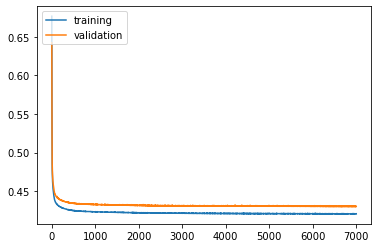

In [49]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

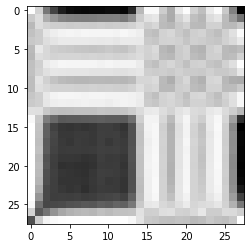

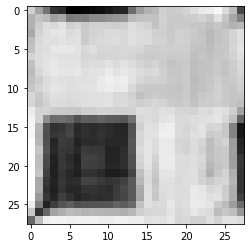

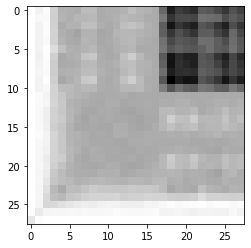

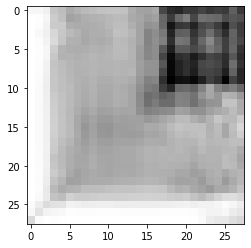

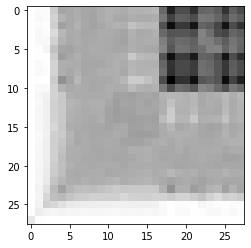

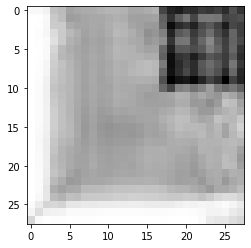

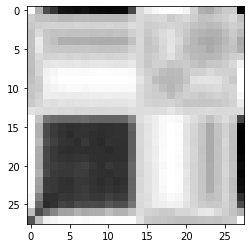

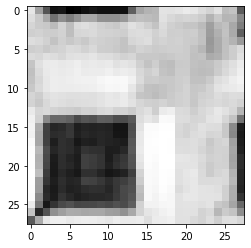

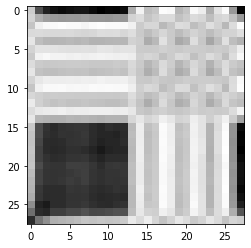

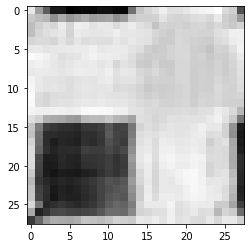

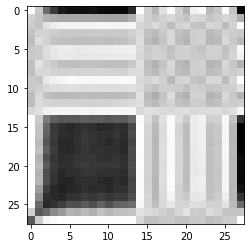

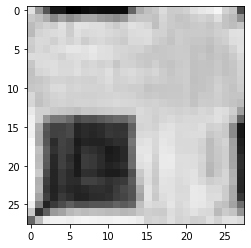

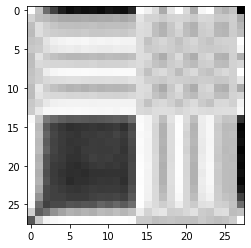

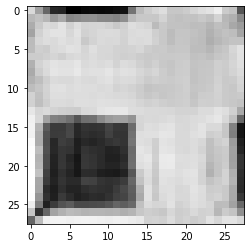

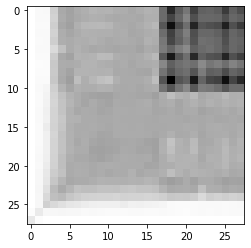

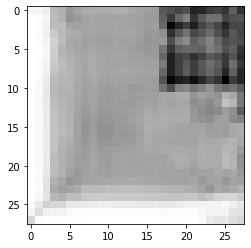

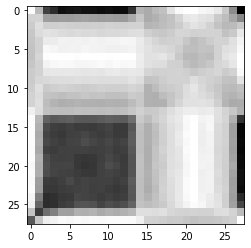

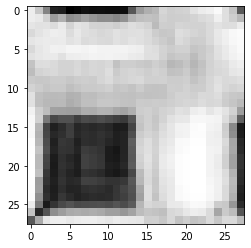

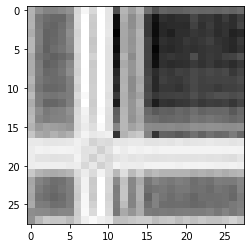

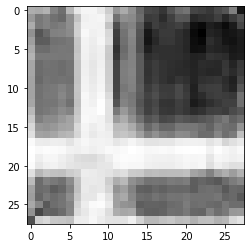

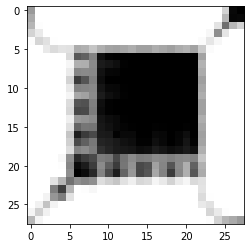

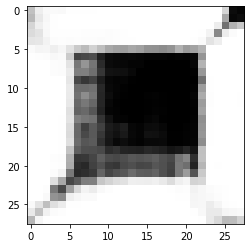

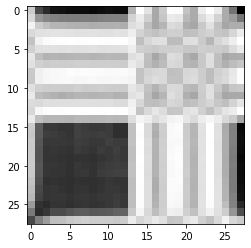

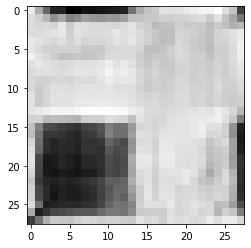

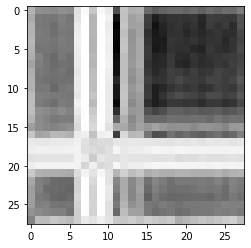

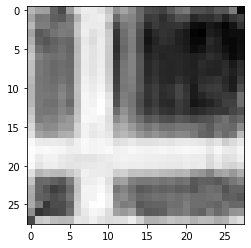

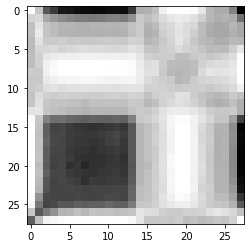

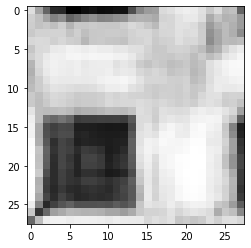

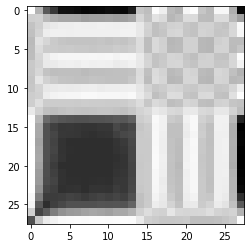

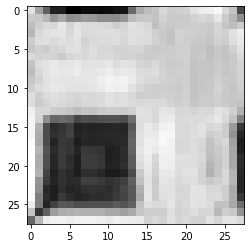

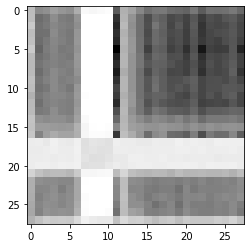

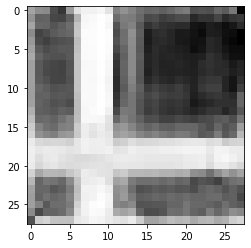

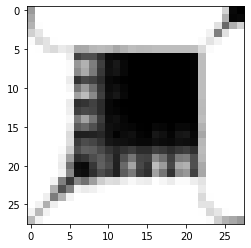

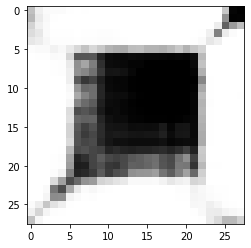

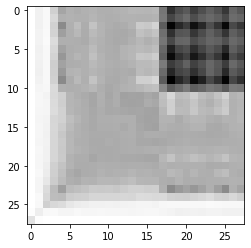

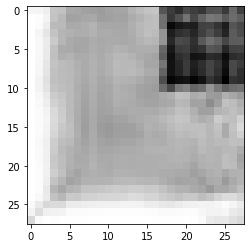

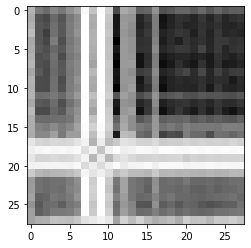

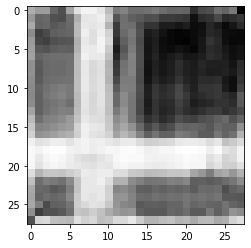

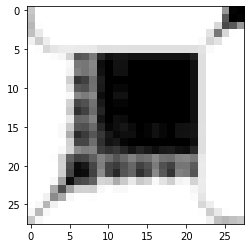

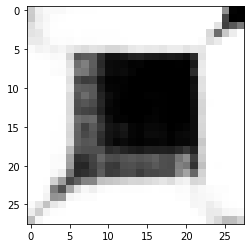

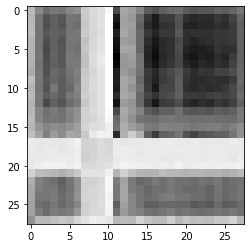

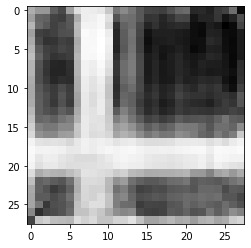

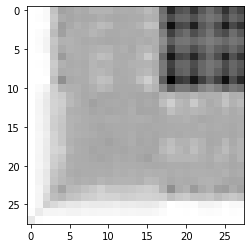

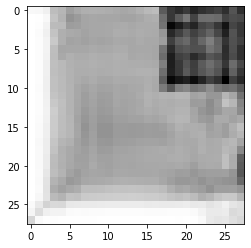

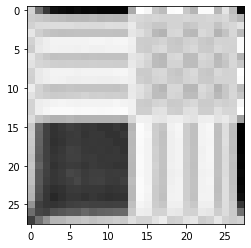

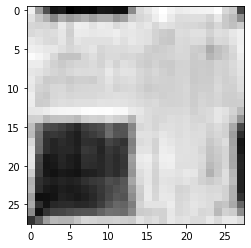

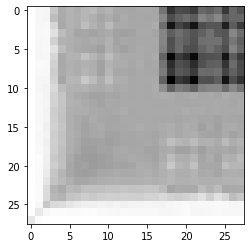

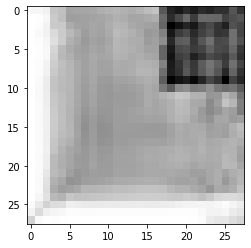

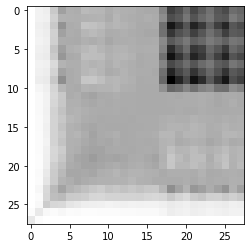

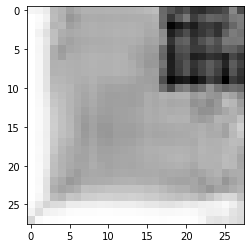

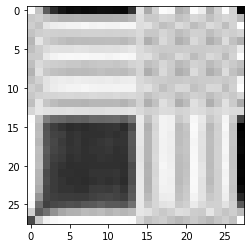

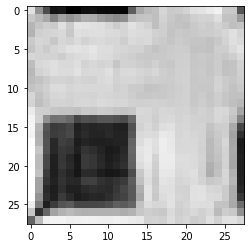

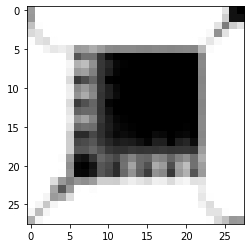

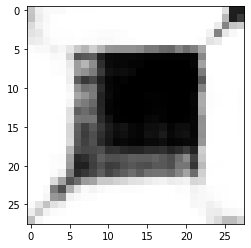

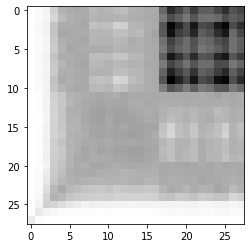

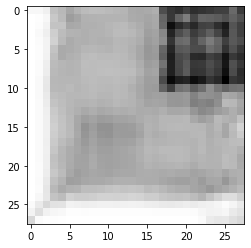

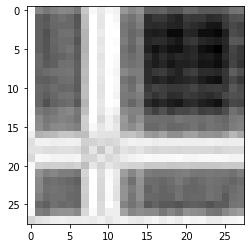

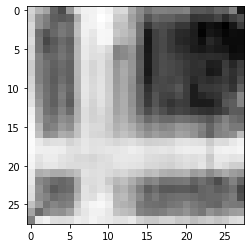

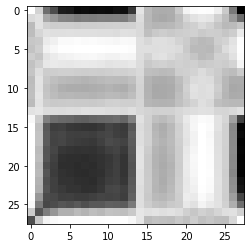

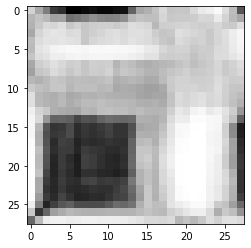

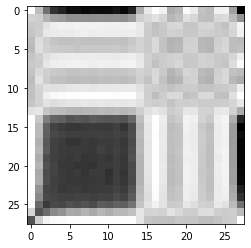

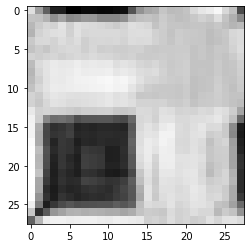

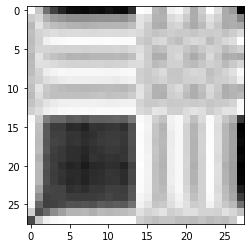

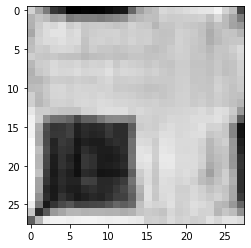

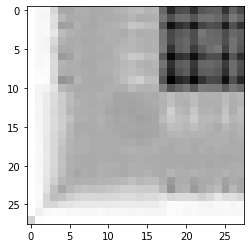

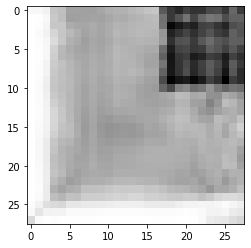

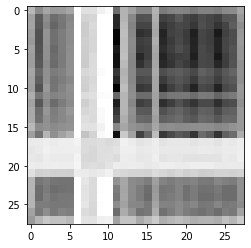

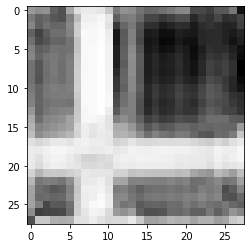

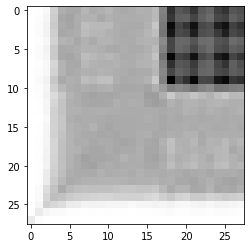

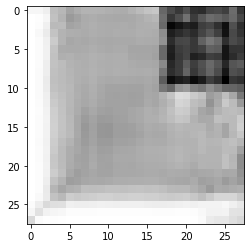

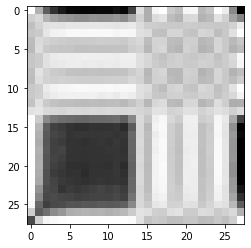

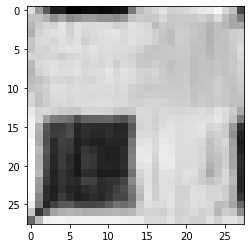

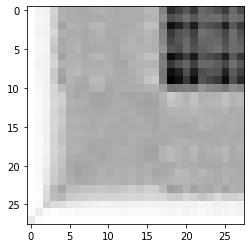

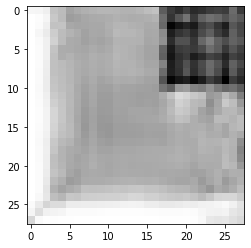

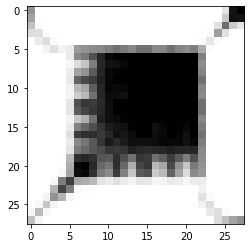

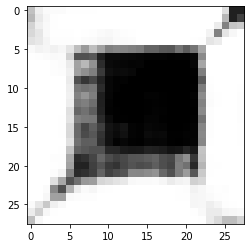

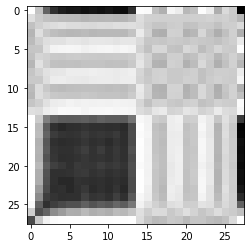

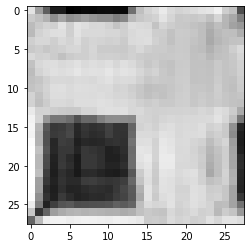

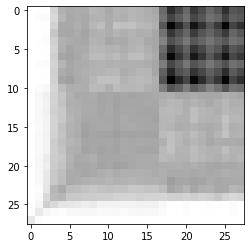

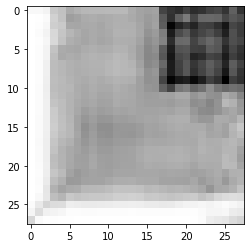

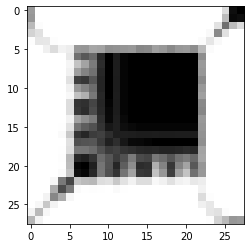

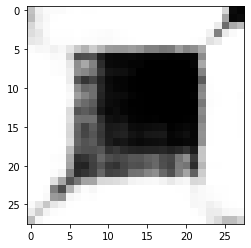

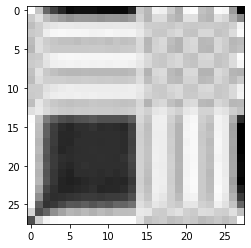

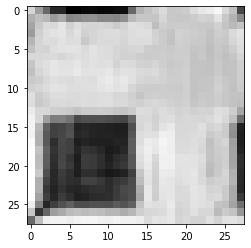

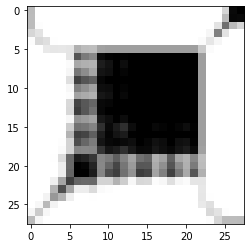

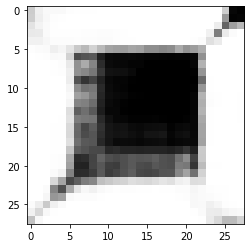

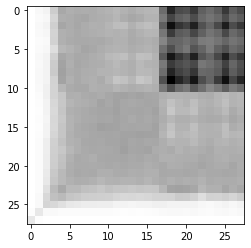

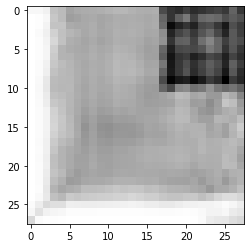

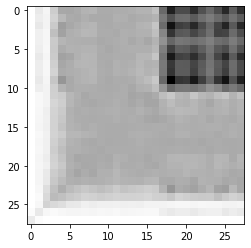

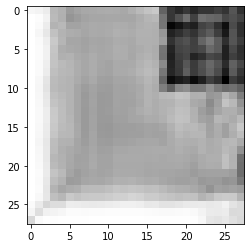

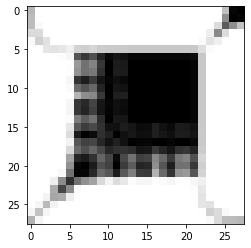

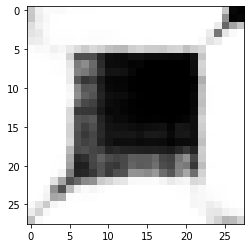

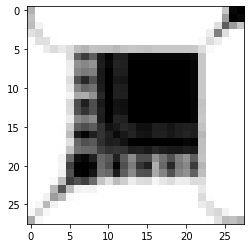

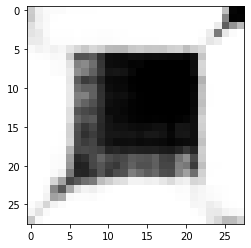

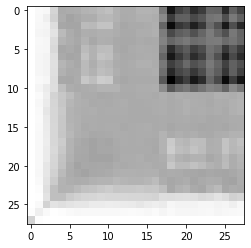

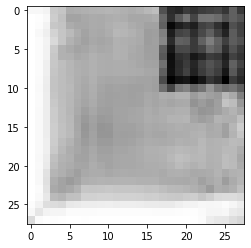

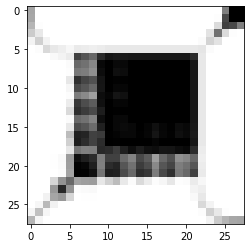

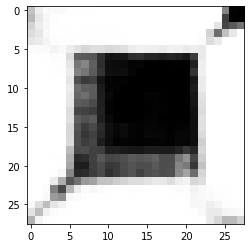

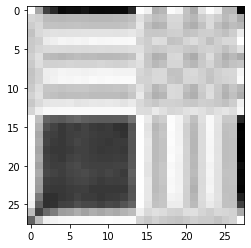

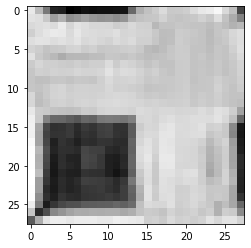

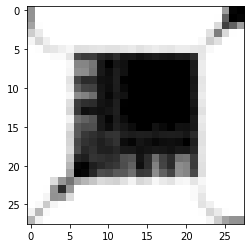

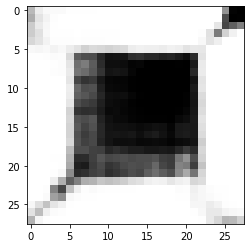

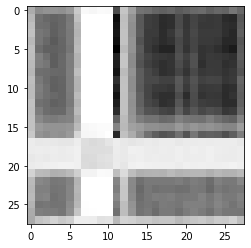

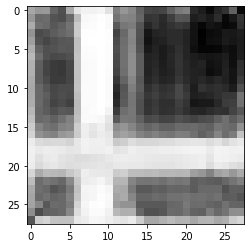

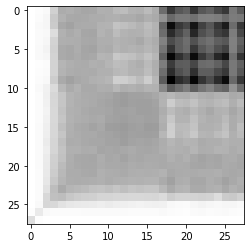

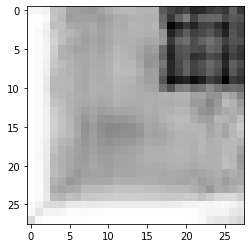

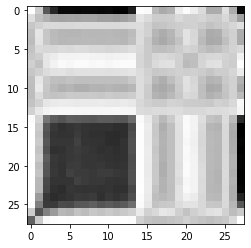

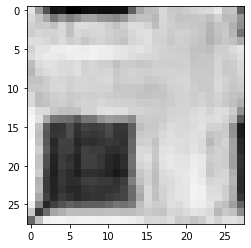

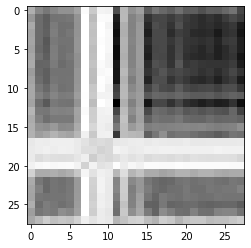

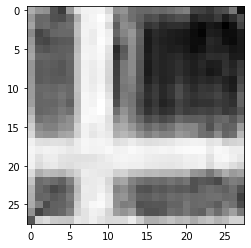

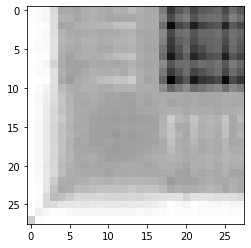

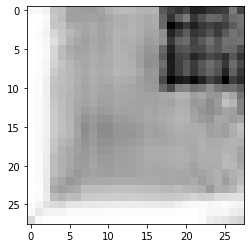

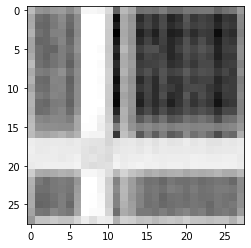

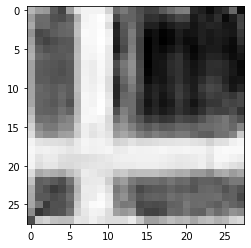

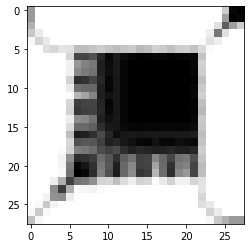

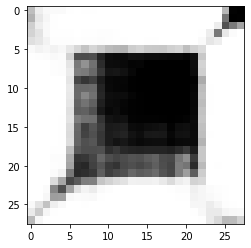

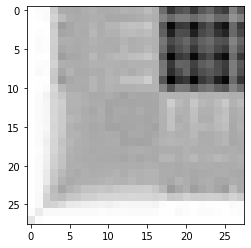

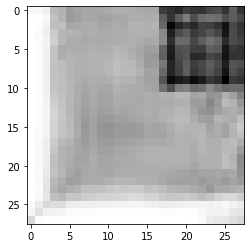

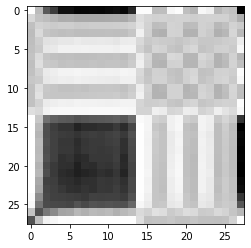

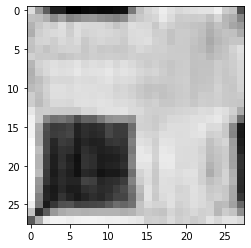

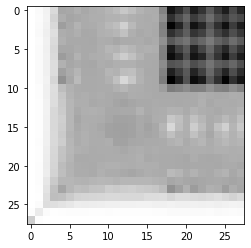

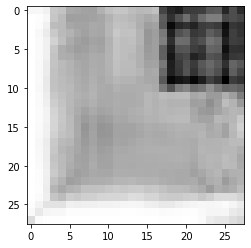

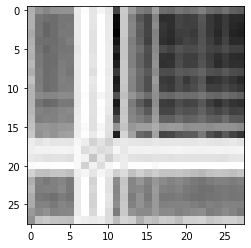

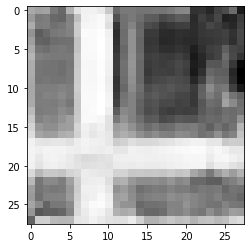

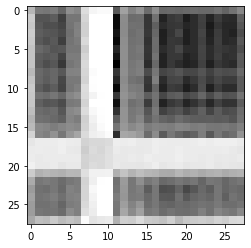

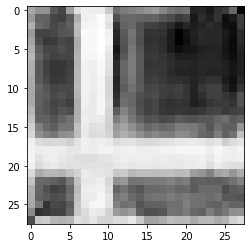

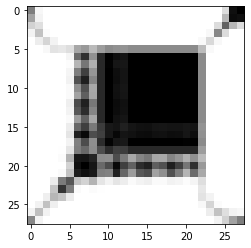

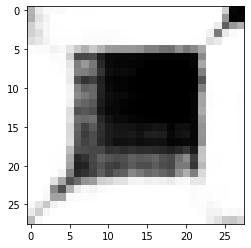

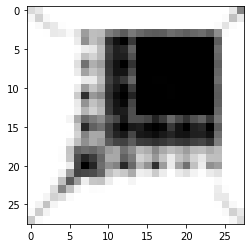

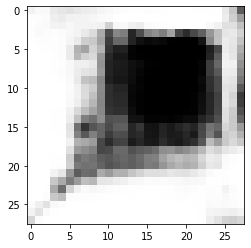

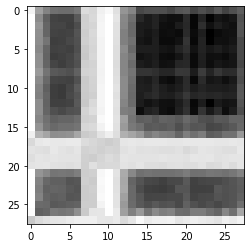

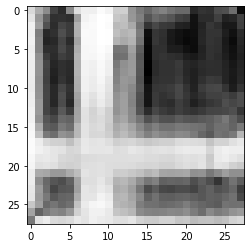

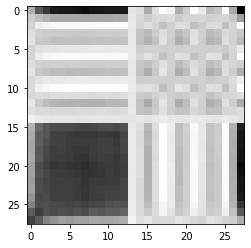

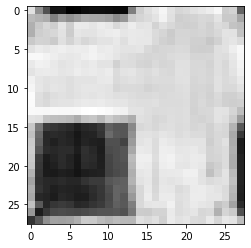

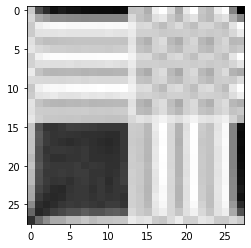

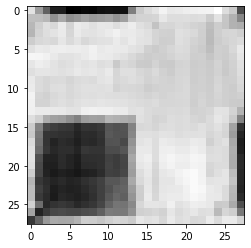

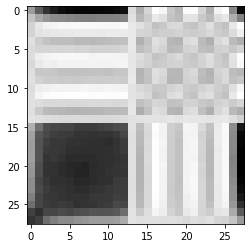

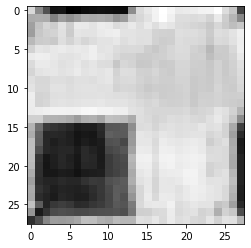

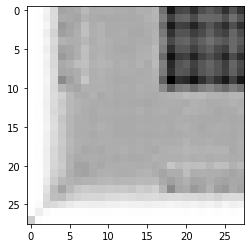

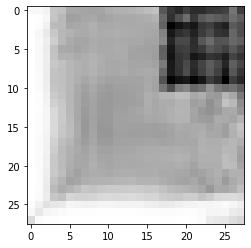

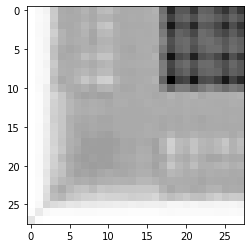

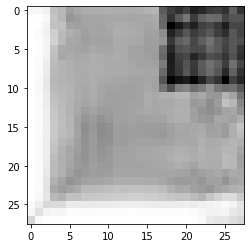

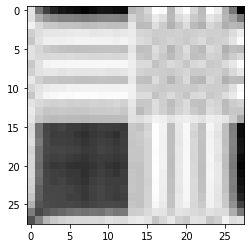

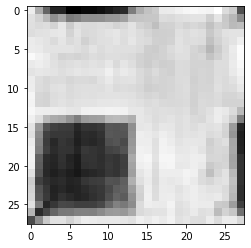

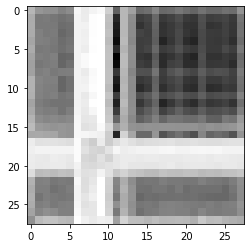

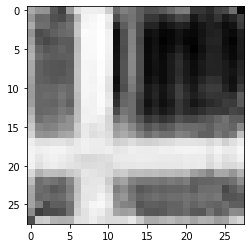

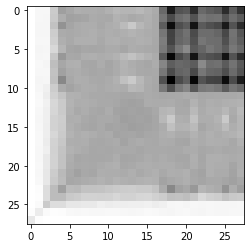

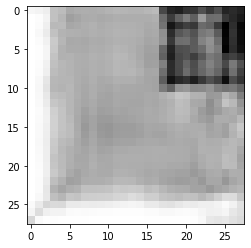

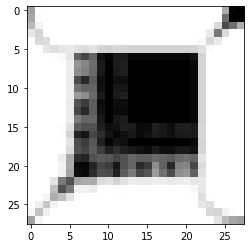

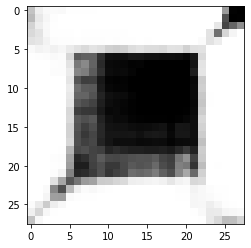

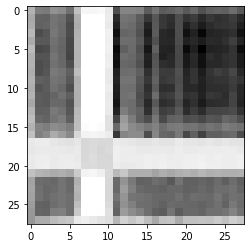

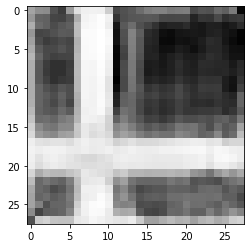

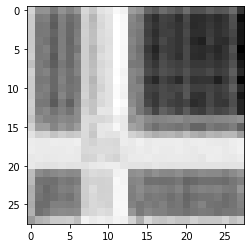

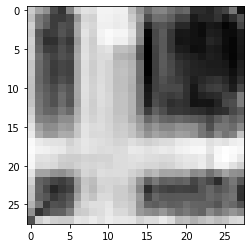

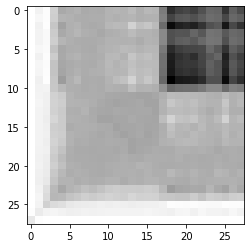

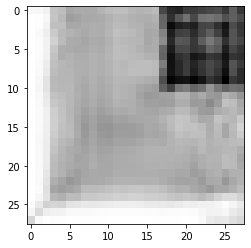

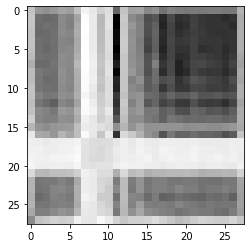

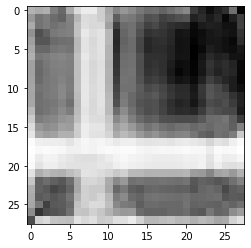

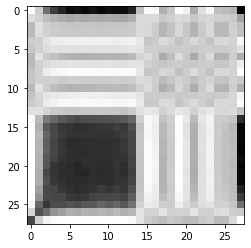

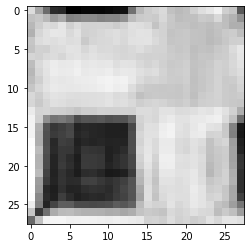

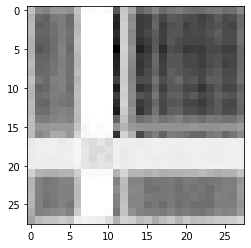

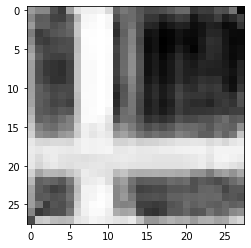

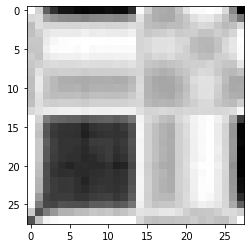

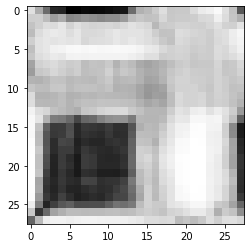

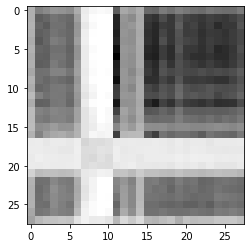

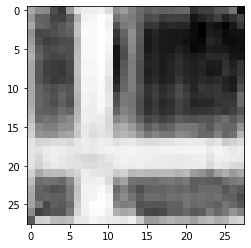

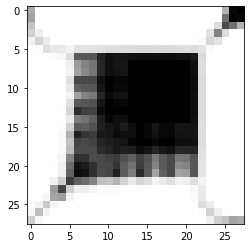

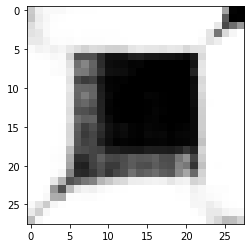

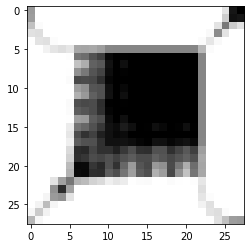

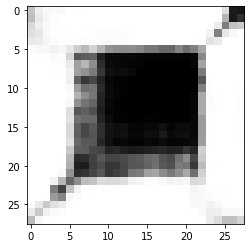

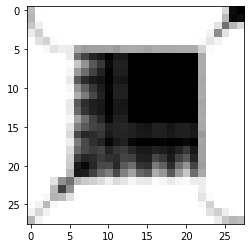

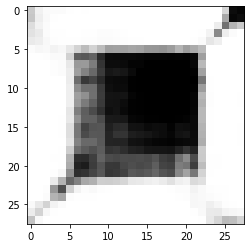

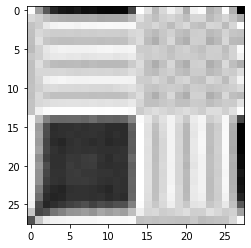

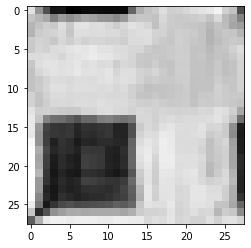

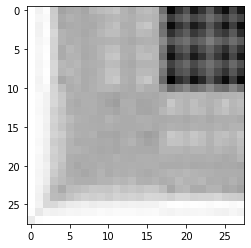

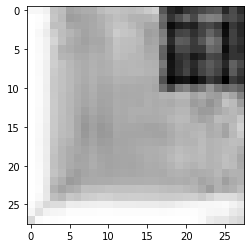

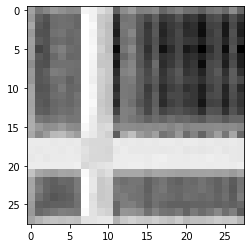

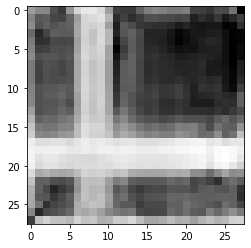

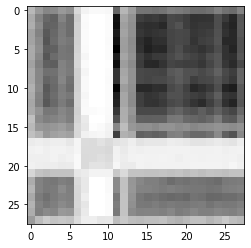

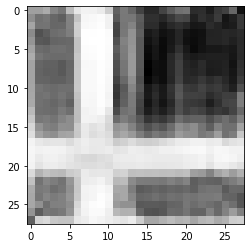

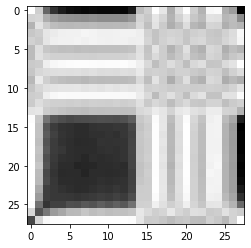

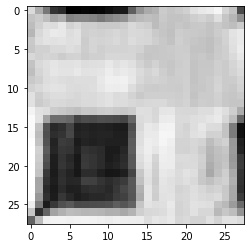

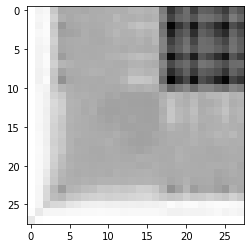

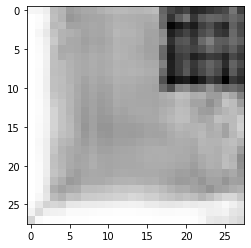

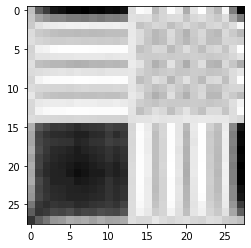

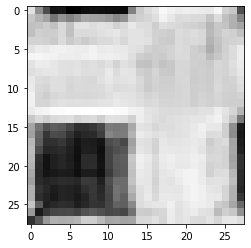

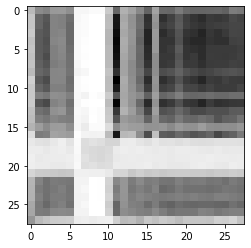

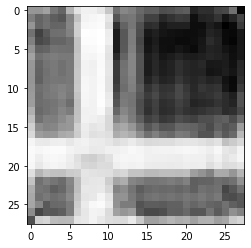

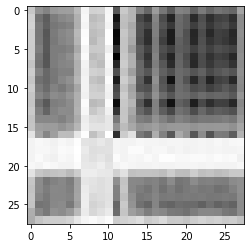

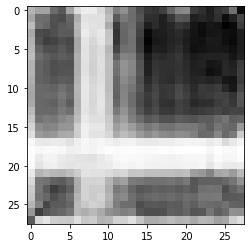

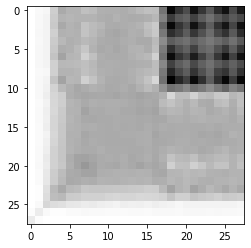

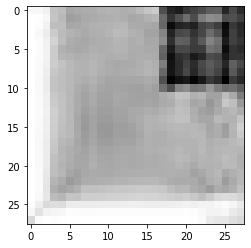

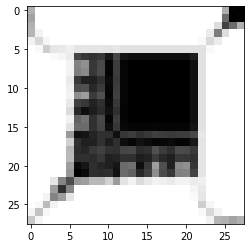

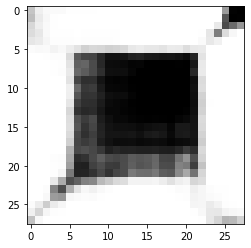

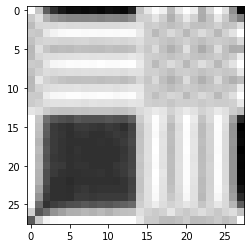

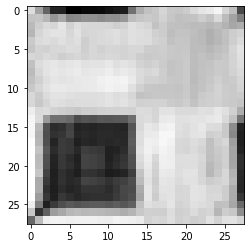

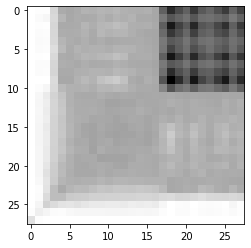

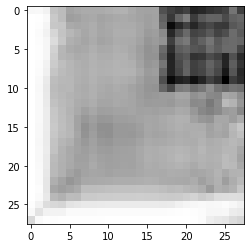

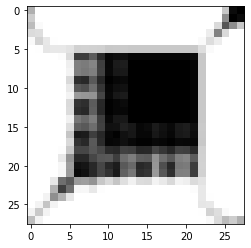

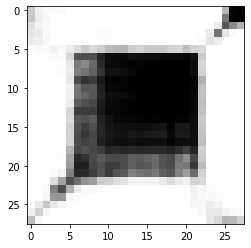

In [50]:
# 모델 복구 (이미지화)
restored_imgs = model.predict(X_test)

for i in range(100):
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    plt.show()
 
    plt.imshow(restored_imgs[i].reshape(28, 28))
    plt.gray()
    plt.show()

### - 모델 테스트

In [52]:
from keras import backend as K

#테스트 진행할 전체 데이터 정규화
X = X.astype('float32') / 255

compressed_layer = 5
get_3rd_layer_output = K.function([model.layers[0].input],[model.layers[compressed_layer].output])

compressed = get_3rd_layer_output([X])[0]

print(compressed.shape)

(760, 7, 7, 2)


## 3. Clustering & Accuracy

In [53]:
# Needed Library!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 삽입!
import Cluster as c

In [54]:
#일렬로 늘리기
compressed = compressed.reshape(760,7*7*2)
print(compressed.shape)
print(compressed)

(760, 98)
[[0.         1.8891847  0.         ... 2.550207   0.         2.3293786 ]
 [0.02882659 2.1286001  0.00544789 ... 2.4862406  0.         2.1961746 ]
 [0.         1.8398571  0.         ... 2.536119   0.         2.2988365 ]
 ...
 [0.09318706 2.0598526  0.11132282 ... 2.2847137  0.         1.8810201 ]
 [0.09483474 2.0841265  0.1292778  ... 2.2571335  0.         1.8845592 ]
 [0.09829566 2.0874767  0.12701476 ... 2.280089   0.         1.9235694 ]]


### - 군집화

In [55]:
result, scaled_x = c.kmeans(compressed, 4, normalization='none')

정규화 진행 안함
Scaled_dataset: 
[[0.         1.8891847  0.         ... 2.550207   0.         2.3293786 ]
 [0.02882659 2.1286001  0.00544789 ... 2.4862406  0.         2.1961746 ]
 [0.         1.8398571  0.         ... 2.536119   0.         2.2988365 ]
 ...
 [0.09318706 2.0598526  0.11132282 ... 2.2847137  0.         1.8810201 ]
 [0.09483474 2.0841265  0.1292778  ... 2.2571335  0.         1.8845592 ]
 [0.09829566 2.0874767  0.12701476 ... 2.280089   0.         1.9235694 ]]


In [56]:
print(scaled_x)
print(result.labels_)
#Y = c.getClassLabelFor([0, 1, 2, 3], 190)
print(Y)

[[0.         1.8891847  0.         ... 2.550207   0.         2.3293786 ]
 [0.02882659 2.1286001  0.00544789 ... 2.4862406  0.         2.1961746 ]
 [0.         1.8398571  0.         ... 2.536119   0.         2.2988365 ]
 ...
 [0.09318706 2.0598526  0.11132282 ... 2.2847137  0.         1.8810201 ]
 [0.09483474 2.0841265  0.1292778  ... 2.2571335  0.         1.8845592 ]
 [0.09829566 2.0874767  0.12701476 ... 2.280089   0.         1.9235694 ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

### - 정확도 측정

In [57]:
i=0
Y_ = Y
for val in Y_:
    if val == 2 :
        Y_[i] = 0
    elif val == 3:
        Y_[i] = 3
    elif val == 5:
        Y_[i] = 2
    elif val == 6:
        Y_[i] = 1
    i += 1

print(Y_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [58]:
accuracy = c.getAccuracy(Y_, result.labels_)
print("Accuracy: {}".format(accuracy))

Accuracy: 1.0
